In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import tensorflow as tfz

from fsmodels import SklMultiExpFrequencyScan
from fsmodels import SklSingleExpFrequencyScan

from fsplots import plot_model
from fsplots import plot_loss_path
from fsplots import plot_experimental_points

%matplotlib inline

# Single exponential model class

In [3]:
fs = SklSingleExpFrequencyScan(filling_pulse = 20*10**-6)
fs

SklSingleExpFrequencyScan()

In [4]:
fs.get_params()

{'filling_pulse': 1.9999999999999998e-05,
 'fit_p_coef': True,
 'learning_rate': 0.1,
 'n_iters': 1000,
 'stop_val': None,
 'verbose': False}

In [5]:
X = np.linspace(0, 3.5, 100)
fs.exps_params_ = [[-2.5, 3.5]]
fs.p_coef_ = 0.3

2022-09-18 08:34:00.310701: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-18 08:34:00.310721: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-09-18 08:34:00.310725: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-09-18 08:34:00.310799: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-18 08:34:00.310812: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-18 08:34:00.310815: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-18 08:34:00.310950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

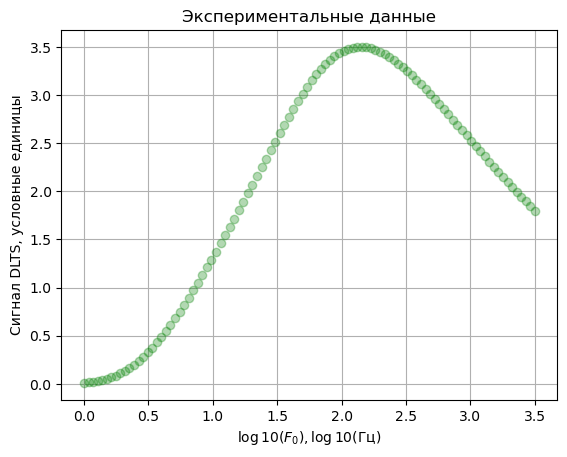

In [6]:
y = fs.predict(X)

plot_experimental_points(X, y)
plt.show()

In [7]:
fs = SklSingleExpFrequencyScan(filling_pulse = 20*10**-6,
                               fit_p_coef = True,
                               learning_rate = 0.1,
                               n_iters = 200, 
                               stop_val = 10**-5,
                               verbose = True)

fs.fit(X, y)

iteration # 0
loss: 4.9125727282022895
exps_params:
[[-1.24523156  0.6775514 ]]
p_coef: 1.0
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 1
loss: 4.738207497553557
exps_params:
[[-1.33315822  0.75449785]]
p_coef: 0.9498035779314699
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 2
loss: 4.5050538099102075
exps_params:
[[-1.43372454  0.84243076]]
p_coef: 0.8883079427744698
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 3
loss: 4.194651407449376
exps_params:
[[-1.54694347  0.9436633 ]]
p_coef: 0.812142405840816
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 4
loss: 3.787090090853569
exps_params:
[[-1.67102524  1.06041848]]
p_coef: 0.7168570613565001
filling_

iteration # 38
loss: 0.019039460183077526
exps_params:
[[-2.5203336   3.24982574]]
p_coef: 0.24074171610222989
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 39
loss: 0.016934027402789452
exps_params:
[[-2.52748232  3.25986377]]
p_coef: 0.26756272274131265
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 40
loss: 0.01466220279272145
exps_params:
[[-2.5195763   3.27566291]]
p_coef: 0.24906589962436076
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 41
loss: 0.013001189510172621
exps_params:
[[-2.5240122   3.28529509]]
p_coef: 0.2675279119599196
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 42
loss: 0.011445993781105583
exps_params:
[[-2.51850446  3.29858261]]

iteration # 74
loss: 0.0003642040156010509
exps_params:
[[-2.50330617  3.46304995]]
p_coef: 0.2929547016657237
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 75
loss: 0.0003277815643501214
exps_params:
[[-2.5031311   3.46494222]]
p_coef: 0.29331524105776025
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 76
loss: 0.0002950143536000949
exps_params:
[[-2.50296562  3.46673706]]
p_coef: 0.2936572258912248
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 77
loss: 0.00026553368218499283
exps_params:
[[-2.5028092   3.46843954]]
p_coef: 0.29398164164124396
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 78
loss: 0.00023900831548032895
exps_params:
[[-2.5026613   3.470

SklSingleExpFrequencyScan(n_iters=200, stop_val=1e-05, verbose=True)

In [8]:
fs.print_all_params()

exps_params:
[[-2.50155655  3.4822787 ]]
p_coef: 0.29661956267799494
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True




In [9]:
fs.fit_results_

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
0,0.677551,0.00002,True,0.1,4.912573,1,200,1.000000,0.00001,-1.245232,True
1,0.754498,0.00002,True,0.1,4.738207,1,200,0.949804,0.00001,-1.333158,True
2,0.842431,0.00002,True,0.1,4.505054,1,200,0.888308,0.00001,-1.433725,True
3,0.943663,0.00002,True,0.1,4.194651,1,200,0.812142,0.00001,-1.546943,True
4,1.060418,0.00002,True,0.1,3.787090,1,200,0.716857,0.00001,-1.671025,True
...,...,...,...,...,...,...,...,...,...,...,...
84,3.478144,0.00002,True,0.1,0.000127,1,200,0.295831,0.00001,-2.501927,True
85,3.479260,0.00002,True,0.1,0.000115,1,200,0.296044,0.00001,-2.501827,True
86,3.480320,0.00002,True,0.1,0.000103,1,200,0.296246,0.00001,-2.501732,True
87,3.481325,0.00002,True,0.1,0.000093,1,200,0.296438,0.00001,-2.501642,True


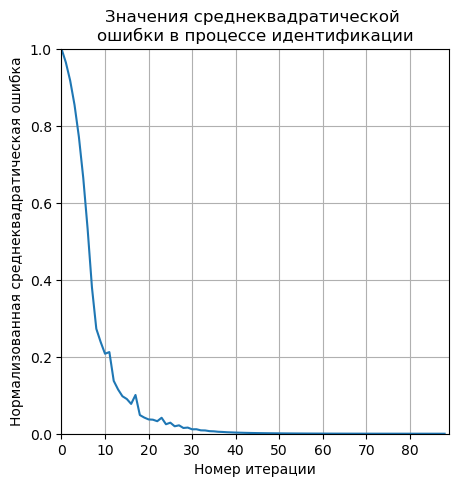

In [10]:
plot_loss_path(fs.fit_results_)
plt.show()

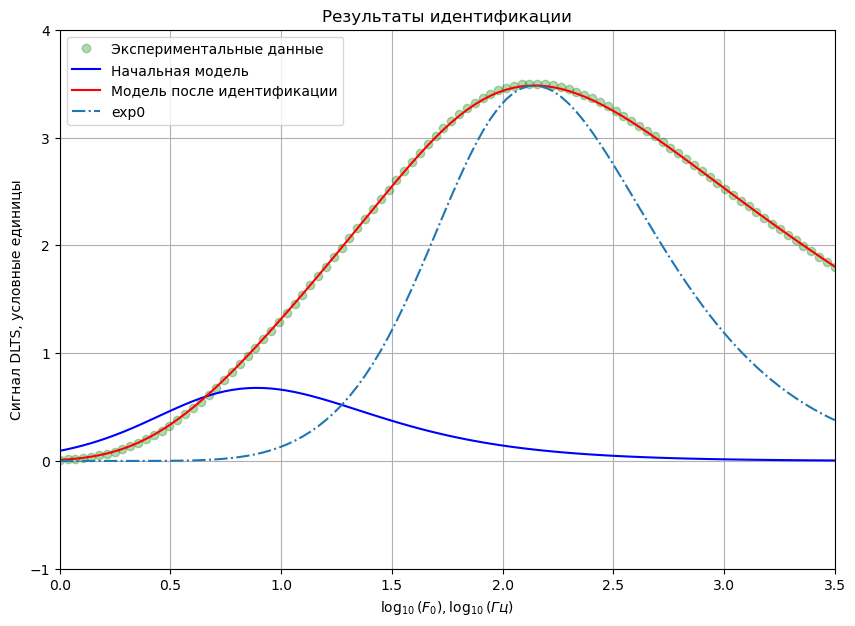

In [11]:
y_pred = fs.predict(X)

plot_model(X, y, SklSingleExpFrequencyScan, fs.fit_results_)
plt.show()

In [12]:
mean_squared_error(y, y_pred, squared=False)

0.009142242314948762

In [13]:
def display_scores(scores):
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

In [14]:
fs = SklSingleExpFrequencyScan(filling_pulse = 20*10**-6,
                               fit_p_coef = True,
                               learning_rate = 0.1,
                               n_iters = 200, 
                               stop_val = 10**-5,
                               verbose = False)

scores = cross_val_score(fs, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
display_scores(np.sqrt(-scores))

2022-09-18 08:34:14.262695: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-18 08:34:14.262716: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-09-18 08:34:14.262721: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-09-18 08:34:14.262795: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-18 08:34:14.262807: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-18 08:34:14.262811: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-18 08:34:14.262931: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores: [0.00373393 0.00670218 0.03320196 0.05811419 0.00876491]
Mean: 0.022103433326440217
Standard deviation: 0.020844688469055163


In [15]:
fs = SklSingleExpFrequencyScan(filling_pulse = 20*10**-6,
                               fit_p_coef = True,
                               learning_rate = 0.1,
                               n_iters = 200, 
                               stop_val = 10**-5,
                               verbose = False)

grid_search = GridSearchCV(fs, {'fit_p_coef': [False, True]}, cv=5, scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)

In [16]:
grid_search.fit(X, y)

2022-09-18 08:34:32.259194: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-18 08:34:32.259217: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-09-18 08:34:32.259221: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-09-18 08:34:32.259333: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-18 08:34:32.259348: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-18 08:34:32.259352: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-18 08:34:32.259515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

GridSearchCV(cv=5,
             estimator=SklSingleExpFrequencyScan(n_iters=200, stop_val=1e-05),
             n_jobs=-1, param_grid={'fit_p_coef': [False, True]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [17]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

1.2876433699846919 {'fit_p_coef': False}
1.3332843448351244 {'fit_p_coef': True}


# Multi exponential model class

In [18]:
fs = SklMultiExpFrequencyScan(filling_pulse = 20*10**-6,
                              n_exps = 3,
                              learning_rate = 0.1,
                              n_iters = 1000, 
                              stop_val = 10**-5,
                              verbose = True)

fs.exps_params_ = [[-1, 1], 
                   [-2, 1], 
                   [-3, 1]]

In [19]:
y = fs.predict(X)

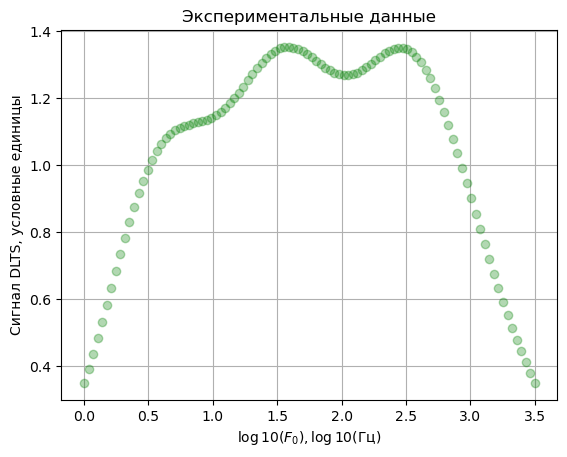

In [20]:
plot_experimental_points(X, y)
plt.show()

In [21]:
fs.fit(X, y)

iteration # 0
loss: 0.7142905545977024
exps_params:
[[-2.40781767  0.12017013]
 [-1.34216693  0.21520485]
 [-2.77904591  0.33152682]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 1
loss: 0.5953334287599072
exps_params:
[[-2.40550288  0.18543645]
 [-1.34521871  0.28498917]
 [-2.77070418  0.388865  ]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 2
loss: 0.4982435464023608
exps_params:
[[-2.40210679  0.24344644]
 [-1.3482589   0.34934591]
 [-2.76249524  0.43996114]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 3
loss: 0.41906740197627806
exps_params:
[[-2.39789732  0.29492472]
 [-1.35085948  0.4087009 ]
 [-2.75483709  0.48544466]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration #

iteration # 33
loss: 0.021166067109661516
exps_params:
[[-2.2454865   0.70369791]
 [-1.20265132  1.09787225]
 [-2.86046156  0.8690987 ]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 34
loss: 0.019739975111743552
exps_params:
[[-2.24094984  0.70724597]
 [-1.19902868  1.10488042]
 [-2.8665397   0.87271255]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 35
loss: 0.01843254461622816
exps_params:
[[-2.23651384  0.71071035]
 [-1.19560055  1.11141725]
 [-2.87245026  0.87620658]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 36
loss: 0.017234154412281863
exps_params:
[[-2.2321848   0.71409843]
 [-1.19235295  1.117507  ]
 [-2.8781862   0.87958728]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


i

iteration # 66
loss: 0.004846584948458551
exps_params:
[[-2.15231899  0.79288878]
 [-1.13644948  1.17714936]
 [-2.97435784  0.9421992 ]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 67
loss: 0.00473788915543274
exps_params:
[[-2.15084473  0.79493398]
 [-1.13524396  1.17695299]
 [-2.97574804  0.94329561]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 68
loss: 0.0046345268656325525
exps_params:
[[-2.14941198  0.79695006]
 [-1.13405963  1.17669433]
 [-2.97707043  0.94434636]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 69
loss: 0.004536026361284386
exps_params:
[[-2.14801833  0.79893773]
 [-1.13289563  1.17637764]
 [-2.97832855  0.9453531 ]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True




iteration # 99
loss: 0.00269173298907312
exps_params:
[[-2.11698846  0.84826272]
 [-1.10463341  1.15334034]
 [-2.99817763  0.96182031]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 100
loss: 0.0026494735158359415
exps_params:
[[-2.11617008  0.84963873]
 [-1.10385132  1.15239372]
 [-2.99850156  0.96208414]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 101
loss: 0.0026079488087531275
exps_params:
[[-2.1153606   0.85100104]
 [-1.10307689  1.15144568]
 [-2.99881398  0.96233764]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 102
loss: 0.0025671385830449834
exps_params:
[[-2.11455979  0.85234989]
 [-1.10230995  1.15049674]
 [-2.99911546  0.9625813 ]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: Tr

iteration # 132
loss: 0.0016080868309287415
exps_params:
[[-2.09377156  0.88746576]
 [-1.08219553  1.12312289]
 [-3.00490361  0.96709082]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 133
loss: 0.00158336131301098
exps_params:
[[-2.09316842  0.88848102]
 [-1.08160707  1.1222755 ]
 [-3.00502745  0.96718774]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 134
loss: 0.0015590235367914811
exps_params:
[[-2.09257024  0.88948742]
 [-1.08102322  1.12143323]
 [-3.00514843  0.96728289]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 135
loss: 0.00153506739745396
exps_params:
[[-2.09197695  0.89048503]
 [-1.08044392  1.1205961 ]
 [-3.00526665  0.96737639]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: Tru

iteration # 165
loss: 0.0009673680262275552
exps_params:
[[-2.07619925  0.91670197]
 [-1.06497881  1.09790415]
 [-3.0078448   0.96974023]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 166
loss: 0.0009527021945482907
exps_params:
[[-2.07573336  0.917463  ]
 [-1.06452132  1.09722676]
 [-3.00790578  0.96981166]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 167
loss: 0.0009382670368994161
exps_params:
[[-2.07527093  0.91821737]
 [-1.06406724  1.09655425]
 [-3.00796548  0.96988292]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 168
loss: 0.0009240589290614534
exps_params:
[[-2.07481192  0.91896514]
 [-1.06361656  1.0958866 ]
 [-3.00802393  0.96995402]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose:

SklMultiExpFrequencyScan(n_exps=3, stop_val=1e-05, verbose=True)

In [22]:
fs.print_all_params()

exps_params:
[[-2.06512724  0.93445962]
 [-1.05412795  1.08180363]
 [-3.00906232  0.97157418]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True




In [23]:
fs.fit_results_

,amplitude_0,amplitude_1,amplitude_2,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,verbose
0,0.120170,0.215205,0.331527,0.00002,0.1,0.714291,3,1000,0.00001,-2.407818,-1.342167,-2.779046,True
1,0.185436,0.284989,0.388865,0.00002,0.1,0.595333,3,1000,0.00001,-2.405503,-1.345219,-2.770704,True
2,0.243446,0.349346,0.439961,0.00002,0.1,0.498244,3,1000,0.00001,-2.402107,-1.348259,-2.762495,True
3,0.294925,0.408701,0.485445,0.00002,0.1,0.419067,3,1000,0.00001,-2.397897,-1.350859,-2.754837,True
4,0.340534,0.463444,0.525887,0.00002,0.1,0.354541,3,1000,0.00001,-2.393109,-1.352707,-2.748024,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.931987,1.084085,0.971292,0.00002,0.1,0.000693,3,1000,0.00001,-2.066699,-1.055663,-3.008920,True
188,0.932614,1.083508,0.971363,0.00002,0.1,0.000682,3,1000,0.00001,-2.066302,-1.055275,-3.008957,True
189,0.933234,1.082936,0.971433,0.00002,0.1,0.000672,3,1000,0.00001,-2.065908,-1.054890,-3.008993,True
190,0.933850,1.082368,0.971504,0.00002,0.1,0.000662,3,1000,0.00001,-2.065516,-1.054508,-3.009028,True


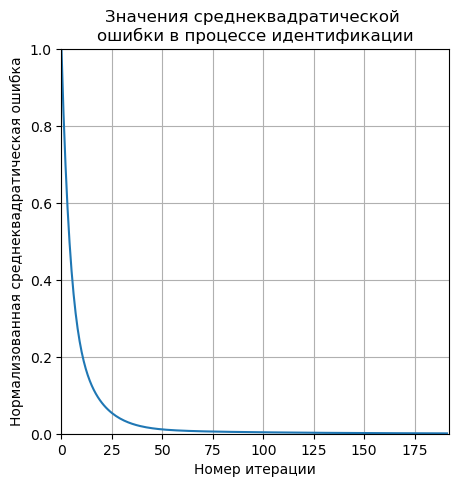

In [24]:
plot_loss_path(fs.fit_results_)
plt.show()

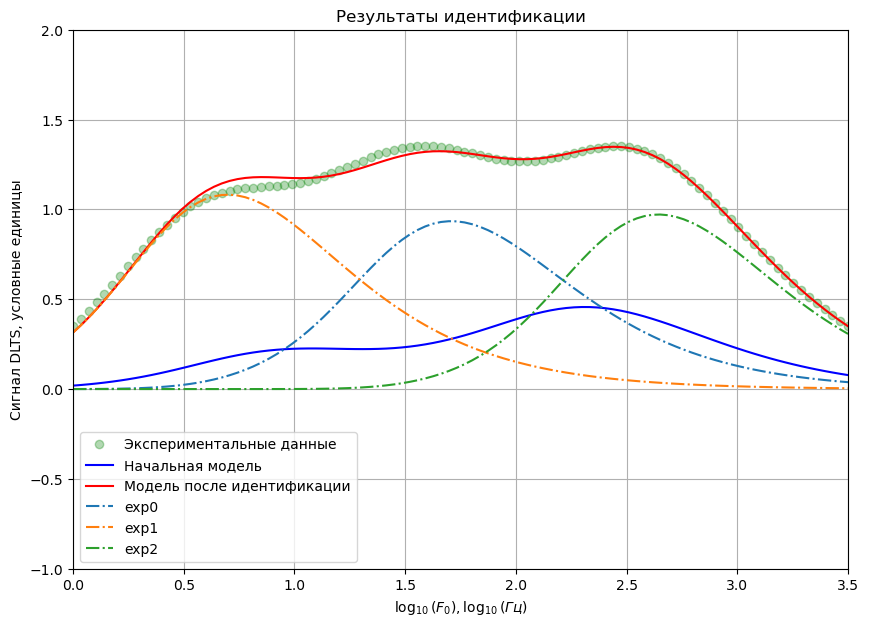

In [25]:
plot_model(X, y, SklMultiExpFrequencyScan, fs.fit_results_)
plt.show()

In [26]:
mean_squared_error(y, fs.predict(X), squared=False)

0.025541525374793855

In [27]:
fs = SklSingleExpFrequencyScan(filling_pulse = 20*10**-6,
                               fit_p_coef = True,
                               learning_rate = 0.1,
                               n_iters = 1000, 
                               stop_val = 10**-5,
                               verbose = False)

scores = cross_val_score(fs, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
display_scores(np.sqrt(-scores))

2022-09-18 08:36:23.750571: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-18 08:36:23.750592: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-09-18 08:36:23.750596: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-09-18 08:36:23.750672: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-18 08:36:23.750685: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-18 08:36:23.750688: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-18 08:36:23.750900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores: [0.18696317 0.11974652 0.07615009 0.30738614 0.40398087]
Mean: 0.21884535932942822
Standard deviation: 0.12108973652506042


In [28]:
fs = SklMultiExpFrequencyScan(filling_pulse = 20*10**-6,
                              n_exps = 3,
                              learning_rate = 0.1,
                              n_iters = 1000, 
                              stop_val = 10**-5,
                              verbose = False)

grid_search = GridSearchCV(fs, {'n_exps': [2, 3, 4, 5, 6]}, cv=5, scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)

In [29]:
grid_search.fit(X, y)

2022-09-18 08:36:43.804232: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-18 08:36:43.804271: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-09-18 08:36:43.804277: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-09-18 08:36:43.804458: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-18 08:36:43.804487: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-18 08:36:43.804494: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-18 08:36:43.804703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

GridSearchCV(cv=5, estimator=SklMultiExpFrequencyScan(n_exps=3, stop_val=1e-05),
             n_jobs=-1, param_grid={'n_exps': [2, 3, 4, 5, 6]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [30]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.45550085793126216 {'n_exps': 2}
0.1578664336633388 {'n_exps': 3}
0.1515272562556811 {'n_exps': 4}
0.12917008409241004 {'n_exps': 5}
0.16255219849239066 {'n_exps': 6}


In [31]:
grid_search.best_estimator_.print_all_params()

exps_params:
[[-2.89021443  0.58693271]
 [-3.24396818  0.36614828]
 [-1.62830102  0.70680607]
 [-2.27448356  0.58382339]
 [-0.90660285  0.7767292 ]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 5
n_iters: 1000
stop_val: 1e-05
verbose: False




In [32]:
grid_search.best_estimator_.fit_results_

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,verbose
0,-0.111047,-0.149831,0.076560,-0.141490,0.003580,0.00002,0.1,1.453943,5,1000,0.00001,-2.932289,-3.327826,-1.645035,-2.231990,-1.149532,False
1,-0.020493,-0.081256,0.171862,-0.038616,0.084459,0.00002,0.1,1.089040,5,1000,0.00001,-2.937105,-3.338496,-1.646700,-2.231792,-1.149669,False
2,0.057695,-0.022572,0.253635,0.049799,0.154848,0.00002,0.1,0.818446,5,1000,0.00001,-2.937875,-3.343565,-1.649736,-2.231706,-1.152229,False
3,0.125419,0.027955,0.323775,0.125789,0.216272,0.00002,0.1,0.616808,5,1000,0.00001,-2.936008,-3.344798,-1.653331,-2.231856,-1.155839,False
4,0.184182,0.071645,0.383851,0.191029,0.269966,0.00002,0.1,0.466279,5,1000,0.00001,-2.932536,-3.343462,-1.656938,-2.232323,-1.159559,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,0.586817,0.366401,0.707409,0.583442,0.774562,0.00002,0.1,0.001365,5,1000,0.00001,-2.889551,-3.245253,-1.626919,-2.275831,-0.909081,False
83,0.586847,0.366335,0.707260,0.583545,0.775126,0.00002,0.1,0.001353,5,1000,0.00001,-2.889711,-3.244928,-1.627268,-2.275491,-0.908421,False
84,0.586876,0.366271,0.707109,0.583643,0.775675,0.00002,0.1,0.001342,5,1000,0.00001,-2.889875,-3.244606,-1.627615,-2.275154,-0.907788,False
85,0.586905,0.366209,0.706958,0.583735,0.776209,0.00002,0.1,0.001332,5,1000,0.00001,-2.890043,-3.244286,-1.627959,-2.274818,-0.907182,False


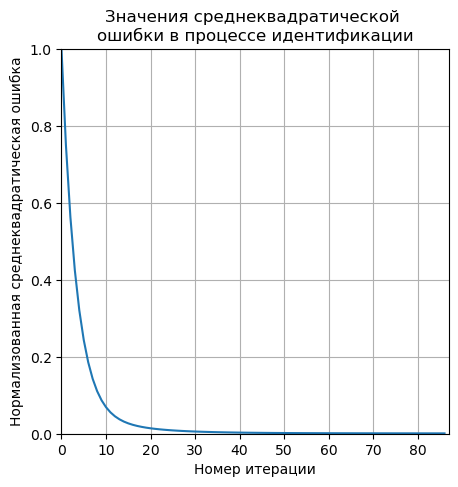

In [33]:
plot_loss_path(grid_search.best_estimator_.fit_results_)
plt.show()

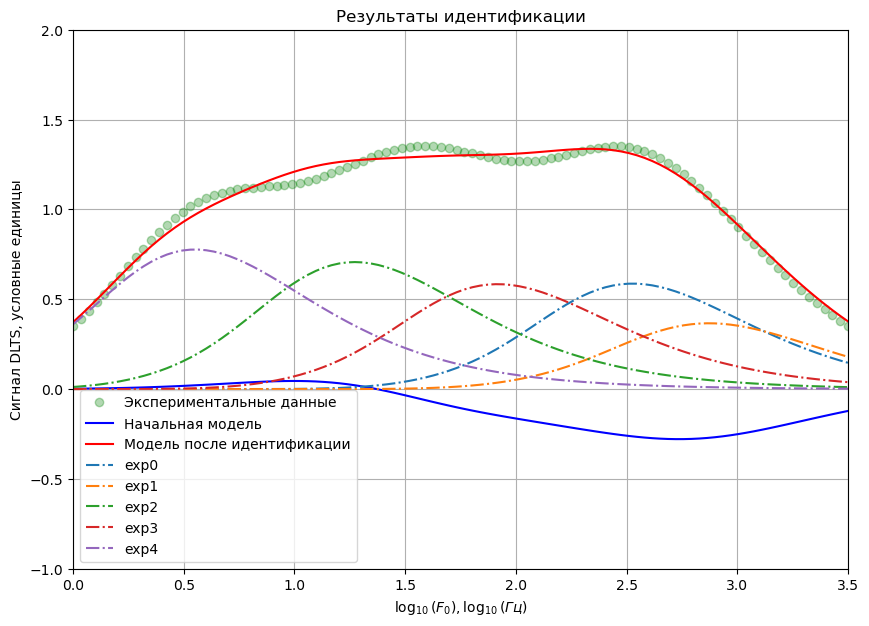

In [34]:
plot_model(X, y, SklMultiExpFrequencyScan, grid_search.best_estimator_.fit_results_)
plt.show()

In [35]:
mean_squared_error(y, grid_search.best_estimator_.predict(X), squared=False)

0.03636037228476407